In [1]:
library(caret, quiet=TRUE);
library(base64enc)
library(httr, quiet=TRUE)



Attaching package: ‘httr’

The following object is masked from ‘package:caret’:

    progress



# Build a Model

In [2]:
set.seed(1960)

create_model  =  function() {

    model  <- train(Species ~ ., data = iris, method = "rpart")
    
    return(model)
}

In [3]:
# dataset
model = create_model()

Rattle: A free graphical interface for data science with R.
Version 5.1.0 Copyright (c) 2006-2017 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.
Warning message:
“Bad 'data' field in model 'call'.
To silence this warning:
    Call prp with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”

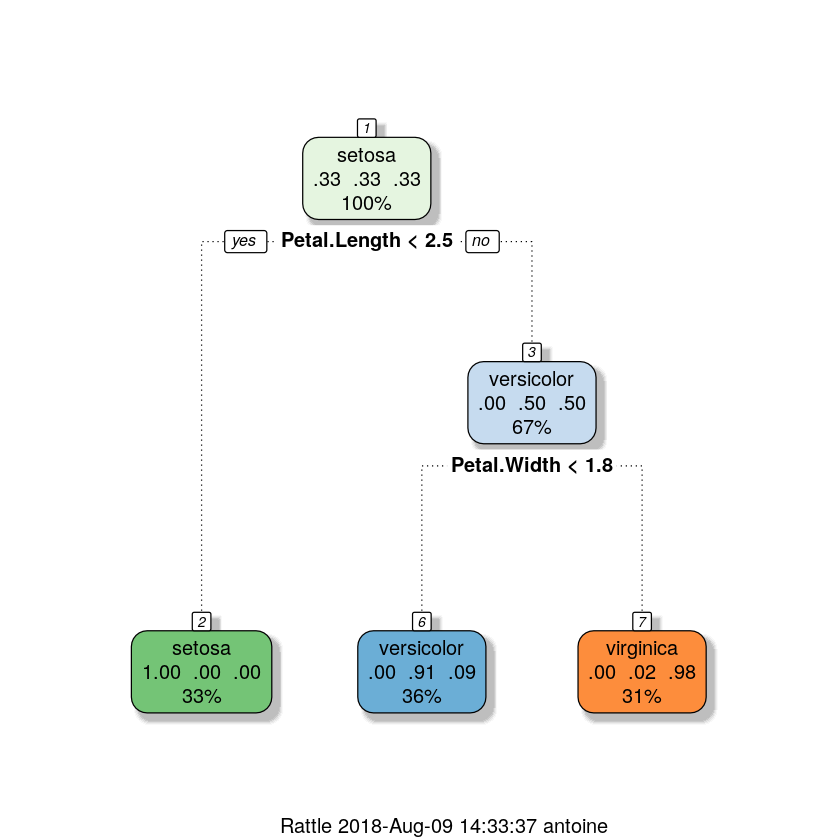

In [4]:
library(rattle, quiet=TRUE)
fancyRpartPlot(model$finalModel)

In [5]:
pred <- predict(model, as.matrix(iris[, -5]) , type="prob")
pred_labels <- predict(model, as.matrix(iris[, -5]) , type="raw")
sum(pred_labels != iris$Species)/length(pred_labels)


[1] 0.04

In [6]:
print(model$finalModel)

n= 150 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 150 100 setosa (0.33333333 0.33333333 0.33333333)  
  2) Petal.Length< 2.45 50   0 setosa (1.00000000 0.00000000 0.00000000) *
  3) Petal.Length>=2.45 100  50 versicolor (0.00000000 0.50000000 0.50000000)  
    6) Petal.Width< 1.75 54   5 versicolor (0.00000000 0.90740741 0.09259259) *
    7) Petal.Width>=1.75 46   1 virginica (0.00000000 0.02173913 0.97826087) *


# SQL Code Generation

In [7]:

test_ws_sql_gen = function(mod) {
    WS_URL = "https://sklearn2sql.herokuapp.com/model"
    WS_URL = "http://localhost:1888/model"
    model_serialized <- serialize(mod, NULL)
    b64_data = base64encode(model_serialized)
    data = list(Name = "caret_rpart_test_model", SerializedModel = b64_data , SQLDialect = "postgresql" , Mode="caret")
    r = POST(WS_URL, body = data, encode = "json")
    # print(r)
    content = content(r)
    # print(content)
    lSQL = content$model$SQLGenrationResult[[1]]$SQL # content["model"]["SQLGenrationResult"][0]["SQL"]
    return(lSQL);
}

In [8]:
lModelSQL = test_ws_sql_gen(model)

In [9]:
cat(lModelSQL)


WITH "DT_node_lookup" AS 
(SELECT "ADS"."KEY" AS "KEY", CASE WHEN ("ADS"."Feature_2" < 2.45) THEN 2 ELSE CASE WHEN ("ADS"."Feature_3" < 1.75) THEN 6 ELSE 7 END END AS node_id_2 
FROM "INPUT_DATA" AS "ADS"), 
"DT_node_data" AS 
(SELECT "Values".nid AS nid, "Values"."P_setosa" AS "P_setosa", "Values"."P_versicolor" AS "P_versicolor", "Values"."P_virginica" AS "P_virginica", "Values"."D" AS "D", "Values"."DP" AS "DP" 
FROM (SELECT 2 AS nid, 1.0 AS "P_setosa", 0.0 AS "P_versicolor", 0.0 AS "P_virginica", 'setosa' AS "D", 1.0 AS "DP" UNION ALL SELECT 6 AS nid, 0.0 AS "P_setosa", 0.9074074074074074 AS "P_versicolor", 0.0925925925925926 AS "P_virginica", 'versicolor' AS "D", 0.9074074074074074 AS "DP" UNION ALL SELECT 7 AS nid, 0.0 AS "P_setosa", 0.021739130434782608 AS "P_versicolor", 0.9782608695652174 AS "P_virginica", 'virginica' AS "D", 0.9782608695652174 AS "DP") AS "Values"), 
"DT_Output" AS 
(SELECT "DT_node_lookup"."KEY" AS "KEY", "DT_node_lookup".node_id_2 AS node_id_2, "DT_node_dat

# Execute the SQL Code

In [10]:
library(RODBC)
conn = odbcConnect("pgsql", uid="db", pwd="db", case="nochange")
odbcSetAutoCommit(conn , autoCommit = TRUE)

[1] 0

In [11]:
dataset = iris[,-5]

df_sql = as.data.frame(dataset)
names(df_sql) = sprintf("Feature_%d",0:(ncol(df_sql)-1))
df_sql$KEY = seq.int(nrow(dataset))

sqlDrop(conn , "INPUT_DATA" , errors = FALSE)
sqlSave(conn, df_sql, tablename = "INPUT_DATA", verbose = FALSE)

head(df_sql)

Feature_0,Feature_1,Feature_2,Feature_3,KEY
5.1,3.5,1.4,0.2,1
4.9,3.0,1.4,0.2,2
4.7,3.2,1.3,0.2,3
4.6,3.1,1.5,0.2,4
5.0,3.6,1.4,0.2,5
5.4,3.9,1.7,0.4,6


In [12]:
# colnames(df_sql)
# odbcGetInfo(conn)
# sqlTables(conn)

In [13]:
df_sql_out = sqlQuery(conn, lModelSQL)
head(df_sql_out)

KEY,Score_setosa,Score_versicolor,Score_virginica,Proba_setosa,Proba_versicolor,Proba_virginica,LogProba_setosa,LogProba_versicolor,LogProba_virginica,Decision,DecisionProba
1,NA,NA,NA,1,0,0,0,-1.797693e+307,-1.797693e+307,setosa,1
2,NA,NA,NA,1,0,0,0,-1.797693e+307,-1.797693e+307,setosa,1
3,NA,NA,NA,1,0,0,0,-1.797693e+307,-1.797693e+307,setosa,1
4,NA,NA,NA,1,0,0,0,-1.797693e+307,-1.797693e+307,setosa,1
5,NA,NA,NA,1,0,0,0,-1.797693e+307,-1.797693e+307,setosa,1
6,NA,NA,NA,1,0,0,0,-1.797693e+307,-1.797693e+307,setosa,1


# R Caret Rpart Output

In [14]:
pred_proba  =  predict(model, as.matrix(iris[,-5]), type = "prob")
df_r_out = data.frame(pred_proba)
names(df_r_out) = sprintf("Proba_%s",model$levels)

df_r_out$KEY = seq.int(nrow(dataset))
df_r_out$Score_setosa  =  NA
df_r_out$Score_versicolor  =  NA
df_r_out$Score_virginica  =  NA
df_r_out$LogProba_setosa  =  log(df_r_out$Proba_setosa)
df_r_out$LogProba_versicolor =  log(df_r_out$Proba_versicolor)
df_r_out$LogProba_virginica  =  log(df_r_out$Proba_virginica)
df_r_out$Decision =   predict(model, as.matrix(iris[,-5]), type = "raw")
df_r_out$DecisionProba =  apply(pred_proba, 1, function(x) max(x))
head(df_r_out)



Proba_setosa,Proba_versicolor,Proba_virginica,KEY,Score_setosa,Score_versicolor,Score_virginica,LogProba_setosa,LogProba_versicolor,LogProba_virginica,Decision,DecisionProba
1,0,0,1,NA,NA,NA,0,-Inf,-Inf,setosa,1
1,0,0,2,NA,NA,NA,0,-Inf,-Inf,setosa,1
1,0,0,3,NA,NA,NA,0,-Inf,-Inf,setosa,1
1,0,0,4,NA,NA,NA,0,-Inf,-Inf,setosa,1
1,0,0,5,NA,NA,NA,0,-Inf,-Inf,setosa,1
1,0,0,6,NA,NA,NA,0,-Inf,-Inf,setosa,1


# Compare R and SQL output

In [15]:
df_merge = merge(x = df_r_out, y = df_sql_out, by = "KEY", all = TRUE, , suffixes = c("_1","_2"))
head(df_merge)

KEY,Proba_setosa_1,Proba_versicolor_1,Proba_virginica_1,Score_setosa_1,Score_versicolor_1,Score_virginica_1,LogProba_setosa_1,LogProba_versicolor_1,LogProba_virginica_1,⋯,Score_versicolor_2,Score_virginica_2,Proba_setosa_2,Proba_versicolor_2,Proba_virginica_2,LogProba_setosa_2,LogProba_versicolor_2,LogProba_virginica_2,Decision_2,DecisionProba_2
1,1,0,0,NA,NA,NA,0,-Inf,-Inf,⋯,NA,NA,1,0,0,0,-1.797693e+307,-1.797693e+307,setosa,1
2,1,0,0,NA,NA,NA,0,-Inf,-Inf,⋯,NA,NA,1,0,0,0,-1.797693e+307,-1.797693e+307,setosa,1
3,1,0,0,NA,NA,NA,0,-Inf,-Inf,⋯,NA,NA,1,0,0,0,-1.797693e+307,-1.797693e+307,setosa,1
4,1,0,0,NA,NA,NA,0,-Inf,-Inf,⋯,NA,NA,1,0,0,0,-1.797693e+307,-1.797693e+307,setosa,1
5,1,0,0,NA,NA,NA,0,-Inf,-Inf,⋯,NA,NA,1,0,0,0,-1.797693e+307,-1.797693e+307,setosa,1
6,1,0,0,NA,NA,NA,0,-Inf,-Inf,⋯,NA,NA,1,0,0,0,-1.797693e+307,-1.797693e+307,setosa,1


In [16]:
diffs_df = df_merge[df_merge$Decision_1 != df_merge$Decision_2,]
head(diffs_df)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”

KEY,Proba_setosa_1,Proba_versicolor_1,Proba_virginica_1,Score_setosa_1,Score_versicolor_1,Score_virginica_1,LogProba_setosa_1,LogProba_versicolor_1,LogProba_virginica_1,⋯,Score_versicolor_2,Score_virginica_2,Proba_setosa_2,Proba_versicolor_2,Proba_virginica_2,LogProba_setosa_2,LogProba_versicolor_2,LogProba_virginica_2,Decision_2,DecisionProba_2


In [17]:
stopifnot(nrow(diffs_df) == 0)

In [18]:
summary(df_sql_out)

      KEY         Score_setosa   Score_versicolor Score_virginica
 Min.   :  1.00   Mode:logical   Mode:logical     Mode:logical   
 1st Qu.: 38.25   NA's:150       NA's:150         NA's:150       
 Median : 75.50                                                  
 Mean   : 75.50                                                  
 3rd Qu.:112.75                                                  
 Max.   :150.00                                                  
  Proba_setosa    Proba_versicolor  Proba_virginica   LogProba_setosa      
 Min.   :0.0000   Min.   :0.00000   Min.   :0.00000   Min.   :-1.798e+307  
 1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:-1.798e+307  
 Median :0.0000   Median :0.02174   Median :0.09259   Median :-1.798e+307  
 Mean   :0.3333   Mean   :0.33333   Mean   :0.33333   Mean   :-1.198e+307  
 3rd Qu.:1.0000   3rd Qu.:0.90741   3rd Qu.:0.97826   3rd Qu.:  0.000e+00  
 Max.   :1.0000   Max.   :0.90741   Max.   :0.97826   Max.   :  0.000e+00  
 LogPr

In [19]:
summary(df_r_out)

  Proba_setosa    Proba_versicolor  Proba_virginica        KEY        
 Min.   :0.0000   Min.   :0.00000   Min.   :0.00000   Min.   :  1.00  
 1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.: 38.25  
 Median :0.0000   Median :0.02174   Median :0.09259   Median : 75.50  
 Mean   :0.3333   Mean   :0.33333   Mean   :0.33333   Mean   : 75.50  
 3rd Qu.:1.0000   3rd Qu.:0.90741   3rd Qu.:0.97826   3rd Qu.:112.75  
 Max.   :1.0000   Max.   :0.90741   Max.   :0.97826   Max.   :150.00  
 Score_setosa   Score_versicolor Score_virginica LogProba_setosa
 Mode:logical   Mode:logical     Mode:logical    Min.   :-Inf   
 NA's:150       NA's:150         NA's:150        1st Qu.:-Inf   
                                                 Median :-Inf   
                                                 Mean   :-Inf   
                                                 3rd Qu.:   0   
                                                 Max.   :   0   
 LogProba_versicolor LogProba_virginica       De